In [15]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from sympy import * 
import random
import yaml
from scipy.integrate import odeint  

from haptic import haptic_class, haptic_actual
from spring_damp import mass_damp_spring 
from random import randint 

number = 5#number of different dynamics +

# m=0.005-0.01, b=0.1-0.2, k=1-10

with open('Human_Auto.yaml') as File: #linear error
    d = yaml.load(File, Loader=yaml.FullLoader)

empty = []

for i in range(10): #lets see how many we can manage to get

    m1 = mass_damp_spring(time = d['time'], increment = d['increment'], state= d['state'], #state_actually doesn't matter for sprring_damp_class
                    force = sin, amplitude= d['args_dict_h']['amplitude'], omega=d['args_dict_h']['omega'], 
                    no_mass = d['args_dict_h']['no_mass'], range_mass= d['args_dict_h']['range_mass'], 
                    no_spring= d['args_dict_h']['no_spring'], range_spring = d['args_dict_h']['range_spring'], 
                    no_damp = d['args_dict_h']['no_damp'], range_damp= d['args_dict_h']['range_damp'], uniform=1) 

    m2 = mass_damp_spring(time = d['time'], increment = d['increment'], state= d['state'], #state_actually doesn't matter for sprring_damp_class
                    force = cos, amplitude= d['args_dict_h']['amplitude'], omega=d['args_dict_h']['omega'], 
                    no_mass = d['args_dict_h']['no_mass'], range_mass= d['args_dict_h']['range_mass'], 
                    no_spring= d['args_dict_h']['no_spring'], range_spring = d['args_dict_h']['range_spring'], 
                    no_damp = d['args_dict_h']['no_damp'], range_damp= d['args_dict_h']['range_damp'], uniform=1)
    
    print(i, len(m1.mass), len(m2.mass))

    hap = haptic_class(dic = d, Theta_h=sin, Theta_a=cos) 
    df = hap.dataframe()

    path = f'Data/Linear_error/linear_error_{i+7}.csv' #if code breaks inbetween change {i+1} to number of files in {Linear_error folder + i}
    # in normal case keep it {i+1}

    df['no_sim'] = i+1 

    df.to_csv(path)
    

In [1]:
x = 1
print(f'x = {x}') 

x = 1


In [37]:
class Data:
    def __init__(self, dic, Theta_h, Theta_a):
        self.dic = dic 
        self.time_array = np.arange(0, dic['time'] + dic['increment'], dic['increment'])
        self.sensor_spring = dic['sensor_spring'] #K_T
        self.sw_mass = dic['sw_mass']
        self.state = dic['state']
        self.Theta_h = Theta_h
        self.Theta_a = Theta_a 
        self.G = dic['G'] # r_s/r_m
        self.T_v = dic['T_v']
        self.J_sm = dic['J_sm'] #[j_s, j_m]
        self.args_dict_h = dic['args_dict_h']
        self.args_dict_a = dic['args_dict_a']

        self.product = int(1 / (dic['increment']))  

        self.theta_h = self._intention(Theta_h, omega = dic['args_dict_h']['omega'], amplitude = dic['args_dict_h']['amplitude'])
        self.theta_a = self._intention(Theta_a, omega = dic['args_dict_a']['omega'], amplitude = dic['args_dict_a']['amplitude'])

        
        
        self.diff_theta_h = self.Diff_theta(Theta_h, self.args_dict_h['omega'], self.args_dict_h['amplitude'] )
        self.diff_theta_a = self.Diff_theta(Theta_a, self.args_dict_a['omega'], self.args_dict_a['amplitude'] )
        
        #self._vector = odeint(self.callback_func, self.state, self.Theta['H_time'], mxstep = 50000000) if self.flag==1 else [0,0,0,0]
        #self.acc_sw, self.acc_s, self.error = self.auto_acc()

    def _intention(self, force, omega, amplitude):
        _list = []
        t = Symbol('t') 
        if force is not None:
            if omega and amplitude is not None:
                f =  ((amplitude) * ( force(omega * t) ) )
                f = lambdify(t, f)
            else:
                f = force(t)
                f = lambdify(t, f) 

            for i in self.time_array:
                _list.append(f(i))
        else:
            _list.append(10) #constant
        
        return _list

    def Diff_theta(self, Theta, w, a):
        diff_theta = []
        t = Symbol('t')
        if a is not None and w is not None:
            y = a * Theta(w * t)
        else :
            y = Theta(t)
        dt = diff(y, t)
        ddt = lambdify(t, dt)
        for i in self.time_array:
            diff_theta.append(ddt(i)) 
        return diff_theta  

    def _item_time(self, _no, _range, uniform):
        '''
        uniform = 1 mean the random numbers generated are decimal and 
        input for range should be or can be in decimal as well [0.01, 0.1]
        '''
        _len = len(self.time_array)
        _time_to_last = [0] * _no
        _item = []
        _final_item_list = []
        k = 0
        for i in range(_no):
            if uniform is not None: 
                _item.append(random.uniform(_range[0], _range[1]))
            else:
                _item.append(randint(_range[0], _range[1]))
        for i in range(_len):
            _time_to_last[randint(0, _len) % _no] += 1 
        for i in _time_to_last:
            for j in range(i):
                _final_item_list.append(_item[k]) 
            k += 1

        return _final_item_list
    
    def values(self):
        theta = {}
        theta['H_mass'] = self._item_time(_no = self.args_dict_h['no_mass'], _range=self.args_dict_h['range_mass'], uniform = 1 )
        theta['H_spring'] = self._item_time(_no = self.args_dict_h['no_spring'], _range=self.args_dict_h['range_spring'], uniform = 1 )
        theta['H_damp'] = self._item_time(_no = self.args_dict_h['no_damp'], _range=self.args_dict_h['range_damp'], uniform = 1 )

        theta['A_mass'] = self._item_time(_no = self.args_dict_a['no_mass'], _range=self.args_dict_a['range_mass'], uniform = 1 )
        theta['A_spring'] = self._item_time(_no = self.args_dict_a['no_spring'], _range=self.args_dict_a['range_spring'], uniform = 1 )
        theta['A_damp'] = self._item_time(_no = self.args_dict_a['no_damp'], _range=self.args_dict_a['range_damp'], uniform = 1 )

        return theta 
    
    def theta_retun(self, name, T):
        self.Theta = self.values() 

        if name=='H_Damp':
            return 

    def callback_func(self, state, t): 
        T_h = int(t * self.product) 
        dx1dt = state[1] 
        b_h = self.Theta['H_damp'][T_h] * (self.diff_theta_h[T_h] - state[1]) 
        k_h = self.Theta['H_spring'][T_h] * (self.theta_h[T_h] - state[0]) 
        K_t = self.sensor_spring * (state[0] - state[2]) 
        j1 = self.sw_mass + self.Theta['H_mass'][T_h] 
        dx2dt = (b_h + k_h - K_t) * (1/j1)
        dx3dt = state[3] 
        b_a = self.G * self.Theta['A_damp'][T_h] * (self.diff_theta_a[T_h] - (self.G * state[3]))
        k_a = self.G * self.Theta['A_spring'][T_h] * (self.theta_a[T_h] - (self.G * state[2])) 
        dx4dt = (b_a + k_a + K_t + self.T_v) * ( 1 / ((self.G **2) * self.J_sm[1] + self.J_sm[0]) ) 
        dxdt = [dx1dt, dx2dt, dx3dt, dx4dt] 
        return dxdt

    def auto_acc(self):
        self._vector = odeint(self.callback_func, self.state, self.time_array, mxstep = 50000000)
        acc_h , acc_a, error = [], [], []
        for i in self.time_array:
            T = int(i * self.product)
            b_h = self.Theta['H_damp'][T] * (self.diff_theta_h[T] - self._vector[:,1][T] )
            k_h = self.Theta['H_spring'][T] * (self.theta_h[T] - self._vector[:,0][T] ) 
            K_t = self.sensor_spring * (self._vector[:,0][T] - self._vector[:,2][T] ) 
            j1 = self.sw_mass + self.Theta['H_mass'][T]  
            acc_h.append( (b_h + k_h - K_t) * (1/j1) )

            b_a = self.G * self.Theta['A_damp'][T] * (self.diff_theta_a[T] - (self.G * self._vector[:,3][T] ) )
            k_a = self.G * self.Theta['A_spring'][T] * (self.theta_a[T] - (self.G * self._vector[:,2][T] ) ) 
            deno = ( 1 / ( (self.G **2) * self.J_sm[1] + self.J_sm[0] ) ) 
            num = (b_a + k_a + K_t + self.T_v) 
            acc_a.append(num * deno) 

            delta_b_h = self.dic['delta_B_H'] * (self.diff_theta_h[T] - self._vector[:,1][T] )
            delta_k_h = self.dic['delta_K_H'] * (self.theta_h[T] - self._vector[:,0][T] ) 
            a = (delta_b_h + delta_k_h) * (1/j1)

            delta_b_a = self.G * self.dic['delta_B_A'] * (self.diff_theta_a[T] - (self.G * self._vector[:,3][T] ) ) 
            delta_k_a = self.G * self.dic['delta_K_A'] * (self.theta_a[T] - (self.G * self._vector[:,2][T] ) )
            b = (delta_b_a + delta_k_a) * deno  
            error.append( [a, b] )

        return acc_h, acc_a, np.asarray(error)
    

    def dataframe(self):
        Acc_sw, Acc_s, error = self.auto_acc()

        D = {
            'sim_number' : i+1,
            'time_step_H' : self.time_array,
            'time_step_A' : self.time_array,
            'theta_H' : self.theta_h,
            'theta_A' : self.theta_a,
            'H_spring' : self.Theta['H_spring'],
            'A_spring' : self.Theta['A_spring'],
            'H_damp' : self.Theta['H_Damp'],
            'A_damp' : self.Theta['A_Damp'],
            'H_mass' : self.Theta['H_mass'],
            'A_mass' : self.Theta['A_mass'],
            'disp_sw': self._vector[:,0],
            'disp_s': self._vector[:, 2],
            'vel_sw': self._vector[:, 1],
            'vel_s': self._vector[:, 3],
            'acc_sw': Acc_sw,
            'acc_s': Acc_s, 
            'error_1': error[:, 0], 
            'error_2': error[:, 1]
        } 

        return pd.DataFrame(D)


In [38]:
with open('Human_Auto.yaml') as File: #linear error
    d = yaml.load(File, Loader=yaml.FullLoader)

new = Data(dic = d, Theta_h = sin, Theta_a = cos)

In [39]:
df = new.dataframe() 

IndexError: list index out of range

In [40]:
a = np.arange(0, 1000+0.01, 0.01)
len(a) 

100001

In [45]:
len(new.Theta['H_damp']), len(new.diff_theta_h)

(100001, 100001)

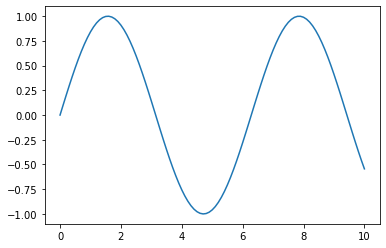

In [7]:
from scipy.integrate import odeint  

time_array = np.arange(0, 10+0.1, 0.1)

def _force_list(force, omega, amplitude):
    _list = []
    t = Symbol('t')
    if force is not None:
        if omega and amplitude is not None:
            f =  ((amplitude) * ( force(omega * t) ) )
            f = lambdify(t, f)
        else:
            f = force(t)
            f = lambdify(t, f) 

        for i in time_array:
            _list.append(f(i))
    else:
        _list.append(10) #constant
    
    return _list

a = _force_list(sin, omega =1, amplitude =1)

plt.plot(time_array, a)


ImportError: cannot import name 'data' from 'Deep_Gp' (/home/sai/Auto/Deep_Gp.py)

'/home/sai/Auto'